<a href="https://colab.research.google.com/github/824zzy/Code_Chips/blob/master/Mixture_Density_Network/CAIC_15_Mixture_Density_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAIC #15 Mixture Density Network with Tensorflow Eager Execution
## Reference:
-  http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/
- https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

## Presention by:
- 824zzy

## Introduction with simple data fitting
Neural nets with even one hidden layer can be universal function approximators, so let's try to fit a sinusoidal function.
$$y_true(x)=7sin(0.75x)+0.5x+\epsilon$$


In [0]:
# import the libraries we need
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

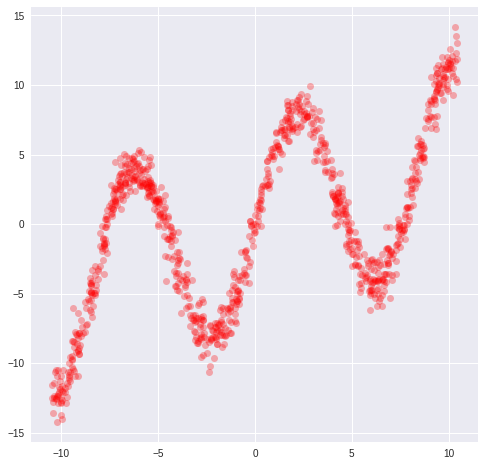

In [0]:
# generate random inputs x to get random samples of y(x)
n_samples = 1000
x_data = tf.random_uniform(shape=(n_samples, 1),
                           minval=-10.5, 
                           maxval=10.5)

r_data = tf.random_normal(shape=(n_samples, 1))
y_data = tf.sin(0.75 * x_data) * 7.0 + x_data * 0.5 + r_data * 1.0

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data.nuempy(), y_data.numpy(), 'ro', alpha=0.3)
plt.show()

### Train a neural network with one hidden layer.
$$y_{pred}(x)=w_{out}tanh(w_{in}x+b_{in})+b_{out},  where: n_{input}=1, n_{hidden}=20, n_{output}=1$$

In [0]:
class simple_nn(tf.keras.Model):
    def __init__(self):
        super(simple_nn, self).__init__()
        self.dense = tf.layers.Dense(20, activation=tf.nn.tanh)
        self.output_layer = tf.layers.Dense(1)
        
    def predict(self, input_data):
        hidden_activation = self.dense(input_data)
        logits = self.output_layer(hidden_activation)
        return logits
    
    def loss(self, input_data, target):
        logits = self.predict(input_data)
        loss = tf.losses.mean_squared_error(target, logits)
#         loss = tf.nn.l2_loss(logits - target)
        return loss
    
    def grads_fn(self, input_data, target):
        with tfe.GradientTape() as tape:
            loss = self.loss(input_data, target)
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=200, verbose=50):
        for i in range(num_epochs):
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if (i==0) | ((i+1)%verbose==0):
                print('Loss at epoch %d: %f' %(i+1, self.loss(input_data, target).numpy()))

x_tensor = tf.constant(x_data)
y_tensor = tf.constant(y_data)
# pytorch default setting
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.01, decay=0.8)
model = simple_nn()
model.fit(x_tensor, y_tensor, optimizer, num_epochs=3000, verbose=300)

Loss at epoch 1: 31.191013
Loss at epoch 300: 18.425266
Loss at epoch 600: 11.165244
Loss at epoch 900: 8.721335
Loss at epoch 1200: 4.866253
Loss at epoch 1500: 1.474389
Loss at epoch 1800: 1.245065
Loss at epoch 2100: 1.220006
Loss at epoch 2400: 1.210507
Loss at epoch 2700: 1.198979
Loss at epoch 3000: 1.189967


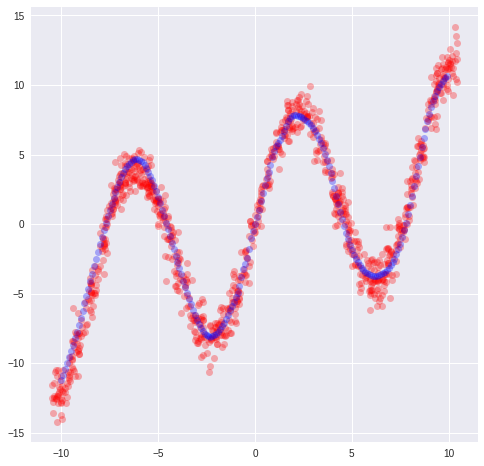

In [0]:
# evenly spaced samples from -10 to 10
x_test = np.float32(np.arange(-10,10,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = model.predict(x_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_test,'bo', alpha=0.3)
plt.show()

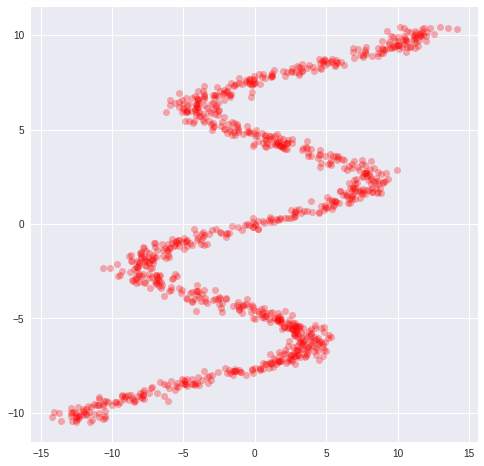

In [0]:
plt.figure(figsize=(8, 8))
plot_out = plt.plot(y_data,x_data,'ro',alpha=0.3)
plt.show()

Loss at epoch 1: 41.526897
Loss at epoch 100: 24.157429
Loss at epoch 200: 22.711706
Loss at epoch 300: 22.225437
Loss at epoch 400: 22.090477
Loss at epoch 500: 22.052540
Loss at epoch 600: 22.031540
Loss at epoch 700: 22.003235
Loss at epoch 800: 21.966494
Loss at epoch 900: 21.937986
Loss at epoch 1000: 21.915527


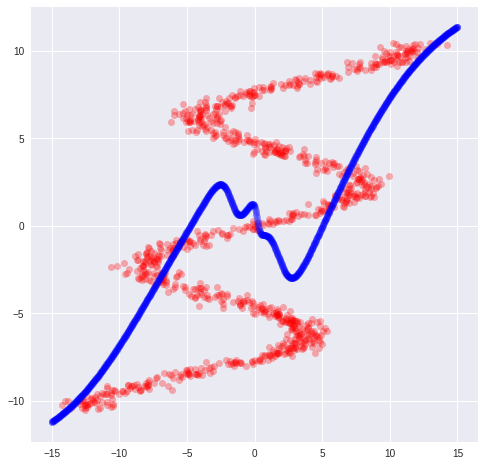

In [0]:
# here we exchange the values of x_data and y_data
x_tensor = tf.constant(y_data)
y_tensor = tf.constant(x_data)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.01, decay=0.8)
model = simple_nn()
model.fit(x_tensor, y_tensor, optimizer, num_epochs=1000, verbose=100)

x_test = np.float32(np.linspace(-15, 15, n_samples))
x_test = x_test.reshape(x_test.size, 1)
y_test = model.predict(x_test)

plt.figure(figsize=(8, 8))
plt.plot(y_data,x_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

### Explanation
Because our network only predicts one output value for each input, this approach will fail miserably.

What we want is a network that has the ability to predict a multiple output values for each input. 

## Go over Mixture Density Network
MDN predicts a probability distribution of possible output values. 

Then can sample several possible different output values for a given input.

for each input $x$, we will predict a probability distribution function $P(y|x)$:
$$p(y|x)=\sum_k^K\Pi_k(x)\phi(y, \mu_k(x), \sigma_k(x))$$
$$s.t. \sum_k^K\Pi_k=1$$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$

### implementation details
1. compute 20 hidden values $z_h$ from our input $x$.
$$z_h(x)=tanh(W_{in}x+b_{in})$$
2. we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$
$$z_{\Pi}=W_{\Pi}z_h+b_{\Pi}$$
$$z_{\sigma}=W_{\sigma}z_h+b_{\sigma}$$
$$z_{\mu}=W_{\mu}z_h+b_{\mu}$$
3. we will use the output of these layers to determine the parameters of the Gaussians.
$$\Pi=\frac{exp(z_\Pi)}{\sum_k^Kexp(z_\Pi k)}$$
$$\sigma=exp(z_\sigma)$$
$$\mu=z_\mu$$
4. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:
$$loss(y|x)=-log[\sum_k^K\Pi_k(x)\phi(y, \mu_k(x), \sigma_k(x))]$$

We use a softmax operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive.

In [0]:
class MDN(tf.keras.Model):
  def __init__(self, n_hidden, n_gaussians):
    super(MDN, self).__init__()
    self.z_h = tf.layers.Dense(n_hidden, activation=tf.tanh)
    self.z_pi = tf.layers.Dense(n_gaussians)
    self.z_sigma = tf.layers.Dense(n_gaussians)
    self.z_mu = tf.layers.Dense(n_gaussians)
    # normalization factor for Gaussians
    self.oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0 * np.pi)
    
  def call(self, x):
    z_h = self.z_h(x)
    pi = tf.nn.softmax(self.z_pi(z_h), -1)
    sigma = tf.exp(self.z_sigma(z_h))
    mu = self.z_mu(z_h)
    return pi, sigma, mu
  
  def gaussian_distribution(self, y, mu, sigma):
    # make |mu|=K copies of y, substract mu, divide by sigma
    result = (tf.broadcast_to(y, mu.shape) - mu) * tf.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (tf.exp(result) * tf.reciprocal(sigma)) * self.oneDivSqrtTwoPI

  def mdn_loss_fn(self, pi, sigma, mu, y):
    result = self.gaussian_distribution(y, mu, sigma) * pi
    result = tf.reduce_sum(result, 1)
    result = -tf.log(result)
    return tf.reduce_mean(result)

  def train_mdn(self, input_data, target, optimizer, num_epochs, verbose=50):
    for epoch in range(10000):
      with tfe.GradientTape() as tape:
        pi, sigma, mu = self.call(input_data)
        loss = self.mdn_loss_fn(pi, sigma, mu, target)  
      grads = tape.gradient(loss, self.variables)
      optimizer.apply_gradients(zip(grads, self.variables))
      if (epoch==0) | ((epoch+1)%verbose==0):
        print('Loss at epoch %d: %f' %(epoch+1, loss))
        
        
network = MDN(n_hidden=20, n_gaussians=5)
const_x = tf.constant(y_data)
const_y = tf.constant(x_data)
optimizer = tf.train.AdamOptimizer()
network.train_mdn(const_x, const_y, optimizer, 10000, verbose=500)
  

Loss at epoch 1: 11.956908
Loss at epoch 500: 3.112775
Loss at epoch 1000: 2.547676
Loss at epoch 1500: 2.480342
Loss at epoch 2000: 2.418534
Loss at epoch 2500: 2.352232
Loss at epoch 3000: 2.265074
Loss at epoch 3500: 2.071137
Loss at epoch 4000: 1.703368
Loss at epoch 4500: 1.506588
Loss at epoch 5000: 1.459580
Loss at epoch 5500: 1.417638
Loss at epoch 6000: 1.383627
Loss at epoch 6500: 1.346159
Loss at epoch 7000: 1.306846
Loss at epoch 7500: 1.283664
Loss at epoch 8000: 1.238758
Loss at epoch 8500: 1.192020
Loss at epoch 9000: 1.184624
Loss at epoch 9500: 1.179239
Loss at epoch 10000: 1.174593


we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

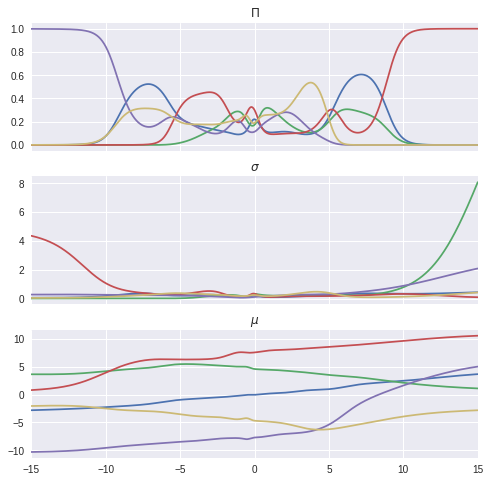

In [0]:
# x_test = np.float32(np.linspace(-15, 15, n_samples))
# x_test = x_test.reshape(x_test.size,1)
pi, sigma, mu = network.call(x_test)
pi = pi.numpy()
sigma = sigma.numpy()
mu = mu.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test, pi)
ax1.set_title('$\Pi$')
ax2.plot(x_test, sigma)
ax2.set_title('$\sigma$')
ax3.plot(x_test, mu)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

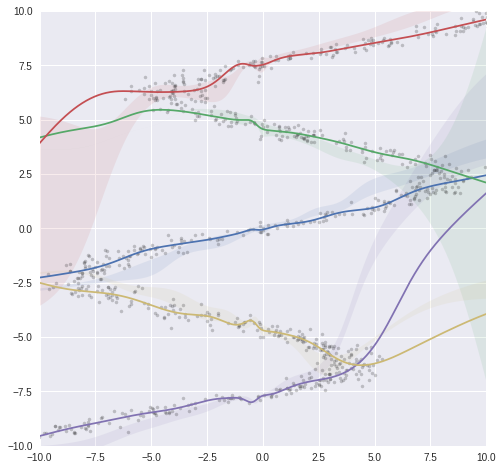

In [0]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu.T, sigma.T):
  plt.plot(x_test, mu_k)
  plt.fill_between(np.linspace(-10, 10, n_samples), mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
  
    
  
plt.scatter(const_x, const_y, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [0]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi)
indices = (np.arange(n_samples), k)

rn = np.random.randn(n_samples)
sampled = rn * sigma[indices] + mu[indices]

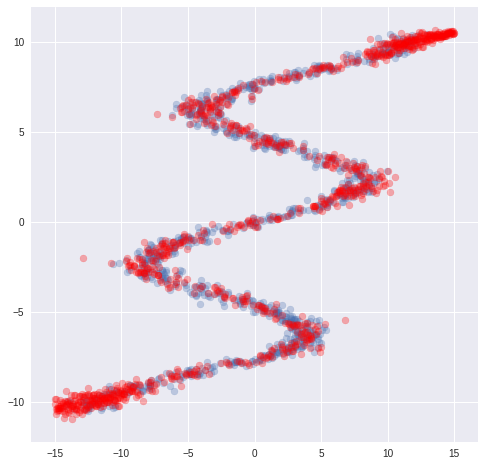

In [0]:
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.3)
plt.scatter(x_test, sampled, alpha=0.3, color='red')
plt.show()

More things we need to focus:
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add sigma += 0.01 inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides Tanh()? Try Sigmoid() too
- What happens when if you use the softplus function for making the $\sigma$ positive, instead of $\exp(x)$?